# Return Prediction with High-Dimensional Data

#### Equity premium prediction with the FRED-MD dataset

https://www.stlouisfed.org/research/economists/mccracken/fred-databases

In [1]:
# Import necessary libraries
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import plot_model

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


2025-03-24 11:23:40.853575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Setting a seed for reproducibility
np.random.seed(0)
random.seed(0)

## Preprocessing

#### Step 1: Download the Data

In [3]:
# Retrieve the data
def load_data(fred_path: str):
    """
    Function to load data either from a local file or from FRED if the file doesn't exist locally.

    Args:
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    DataFrame: Loaded dataset.
    """
    
    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path,)[:-3]
    print("Done")

    tcodes = df.iloc[0, 1:]  # data tickers
    df.drop(0, inplace=True) # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df, tcodes

#### Step 2: Transform the Data

In [4]:
def transxf(x, tcode):
    """
    DESCRIPTION:
    This function transforms a single series (in a column vector)
    as specified by a given transformation code.

    INPUT:
        x      : Series (in a column vector) to be transformed
        tcode  : Transformation code (1-7)

    OUTPUT:
        result : Transformed series (as a column vector)

    """
    # Number of observations (including missing values)
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result to ensure it's always defined
    result = np.nan * np.ones(n)

    # Transformation logic
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result

#### Step 3: Define the Target Variable 

In [5]:
# Define the target variable (S&P 500 Returns)
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable (S&P 500 log returns) and removing NaNs.

    Args:
    df (DataFrame): Data containing S&P 500 returns.

    Returns:
    DataFrame: Processed data with target variable.
    """
    df['Target'] = df['S&P 500'].shift(periods=-1)
    df.drop(['S&P 500', 'VIXCLSx'], axis=1, inplace=True)
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    df.dropna(inplace=True)

    return df

## Estimating the Models

In [6]:
def neural_netork(input_dim):
  model = Sequential()

  model.add(Dense(16, input_shape=(input_dim,), activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(4, activation='relu'))

  # A single Dense layer (perceptron) with 1 unit and a linear activation function
  model.add(Dense(1, activation='linear'))

  # Compile the model
  # The optimizer is set to 'adam', and the loss function to 'mean_squared_error'
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='mean_squared_error'
                )

  return model

In [7]:
# Estimating the Forecasting Models
def train_models(train_data_scaled, train_pca, alpha, input_dim):
    """
    Train multiple forecasting models (OLS, PCA-OLS, LASSO).

    Args:
    train_data_scaled (DataFrame): Scaled training data.
    train_pca (DataFrame): Training data after applying PCA.
    input_dim (int): Input dimension for the neural network model.

    Returns:
    Dict: Trained models.
    """
    models = {
        'ols': LinearRegression(fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                        train_data_scaled["Target"]),
        'ols_pca': LinearRegression(fit_intercept=True).fit(train_pca, train_data_scaled["Target"]),
        'lasso': Lasso(alpha=alpha, fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled['Target'])
    }

    # Neural Network training
    ann_model = neural_netork(input_dim)

    # Train the neural network model
    history = ann_model.fit(
        train_data_scaled.drop("Target", axis=1),
        train_data_scaled["Target"],
        epochs=10,
        batch_size=16,
        validation_split=0.2,
        verbose=0,
        shuffle=False
    )

    # Add the trained ANN model to the models dictionary
    models['ann'] = ann_model

    return models, history

## Generating the Forecasts

In [8]:
# Forecasts from the trained models
def generate_forecasts(models, test_data_scaled, test_pca):
    """
    Generate forecasts from the trained models.

    Args:
    models (Dict): Dictionary of trained models.
    test_data_scaled (DataFrame): Scaled test data.
    test_pca (DataFrame): Test data after applying PCA.

    Returns:
    Dict: Forecasts from each model.
    """

    forecasts = {
        'ols': models['ols'].predict(test_data_scaled.drop("Target", axis=1)),
        'ols_pca': models['ols_pca'].predict(test_pca),
        'lasso': models['lasso'].predict(test_data_scaled.drop("Target", axis=1)),
        'ann': models['ann'].predict(test_data_scaled.drop("Target", axis=1))
    }

    return forecasts

## Evaluating the Forecasts

In [9]:
# Evaluation of the models
def evaluate_models(forecast_results, actual_values):
    """
    Evaluate the models' performance using Mean Squared Error and Mean Absolute Error.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.

    Returns:
    None
    """

    target = np.array(actual_values)
    # Iterate through all models
    for model_name, forecast_list in list(forecast_results.items()):
        forecast = np.array(forecast_list)
        mse = mean_squared_error(target, forecast)
        mae = mean_absolute_error(target, forecast)
        print(f"{model_name}: MSE = {mse}, MAE = {mae}", len(forecast_list))

In [10]:
# Visualize the forecasts
def plot_forecasts(forecast_results, actual_values, test_indices):
    """
    Plot the forecasts alongside the observed values.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.
    test_indices (List): Indices (dates) corresponding to the test data.

    Returns:
    None
    """

    plt.figure(figsize=(12,6))
    plt.plot(test_indices, actual_values, linewidth=1, color='black', label='Observed')
    for model_name, forecast_list in list(forecast_results.items()):
            plt.plot(test_indices, forecast_list, '--', linewidth=1, label=model_name)
    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.show()

## Execute the Code

Be patient: loading from FRED (2 minutes)
Done


/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_1616/3778542039.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dum = transxf(df.iloc[:, i].values, tcodes[i])


1/1 [==============================] - 0s 66ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-02, tolerance: 1.240e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.032e-02, tolerance: 1.250e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-02, tolerance: 1.260e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.858e-02, tolerance: 1.270e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-02, tolerance: 1.510e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e-02, tolerance: 1.570e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 65ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.303e-02, tolerance: 1.580e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.247e-02, tolerance: 1.590e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.217e-02, tolerance: 1.630e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e-02, tolerance: 1.700e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.338e-02, tolerance: 1.720e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e-02, tolerance: 2.030e-02
  model = cd_fast.enet_coordinate_descent(


1/1 [==============================] - 0s 66ms/step
ols: MSE = 49.978993013938656, MAE = 2.10035560655078 271
ols_pca: MSE = 1.3297155971184755, MAE = 0.756609824890519 271
lasso: MSE = 3.0546966327345104, MAE = 1.0645860812856878 271
ann: MSE = 4.336720617265565, MAE = 0.9983508296700552 271


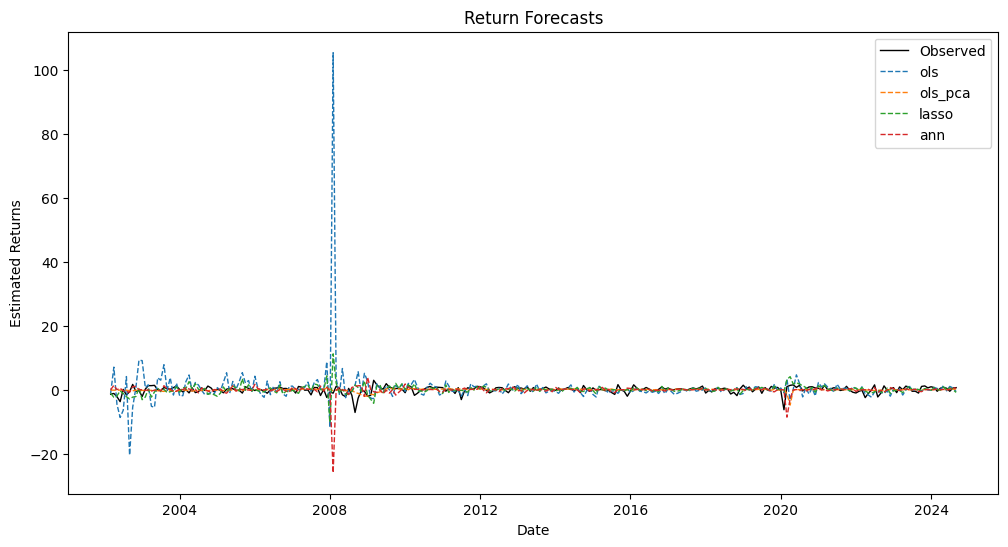

In [16]:
# Define paths for the dataset
fred_path = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64"

# Load the data
df, tcodes = load_data(fred_path)

yt = []  # Initialize output variable
N = df.shape[1]  # Number of series kept

for i in range(N):
    dum = transxf(df.iloc[:, i].values, tcodes[i])
    yt.append(dum)

transformed_data = pd.DataFrame(yt).T
transformed_data.columns = df.columns
transformed_data.index = df.index

# Preprocess the data
df = preprocess_data(transformed_data)

# Define initial training window size
initial_window_size = int(120)

# Initialize lists to store forecasts and actual values
forecast_results = {
    'ols': [],
    'ols_pca': [],
    'lasso': [],
    'ann': []
}

find_alpha = False

actual_values = []
test_indices = []


# Loop over the time steps
for t in range(initial_window_size, len(df)-1):

    # Get training data up to time t
    train_data = df.iloc[:t].copy()

    # Get test data at time t+1
    test_data = df.iloc[t:t+1].copy()

    # Check for NaN in train_data or test_data, skip if necessary
    if train_data.isnull().values.any() or test_data.isnull().values.any():
        continue  # Skip this iteration if there are NaN values

    # Scaling
    scaler = StandardScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

    # Apply PCA
    pca = PCA(n_components=4, whiten=True, svd_solver='full')
    pca.fit(train_data_scaled.drop("Target", axis=1))

    train_pca = pd.DataFrame(pca.transform(train_data_scaled.drop("Target", axis=1)), index=train_data_scaled.index)
    test_pca = pd.DataFrame(pca.transform(test_data_scaled.drop("Target", axis=1)), index=test_data_scaled.index)

    # Get input dimension for neural network
    input_dim = len(train_data_scaled.columns) - 1  # Exclude the target column

    # Find lasso alpha via cv
    if find_alpha:
        alpha = float(LassoCV(cv=3).fit(train_data_scaled.drop("Target", axis=1), train_data_scaled['Target']).alpha_)
    else:
        alpha = 0.005

    # Train models
    models, history = train_models(train_data_scaled, train_pca, alpha, input_dim)

    # Generate forecasts
    test_forecasts = generate_forecasts(models, test_data_scaled, test_pca)

    # Store forecasts
    for model_name in forecast_results.keys():
        forecast_results[model_name].append(test_forecasts[model_name][0])

    # Store actual value
    actual_values.append(test_data_scaled["Target"].values[0])

    # Store test index
    test_indices.append(test_data.index[0])

# Evaluate models
evaluate_models(forecast_results, actual_values)

# Plot forecasts
plot_forecasts(forecast_results, actual_values, test_indices)